In [1]:
#importing
import pandas as pd

from sklearn.cross_validation import KFold

import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 500
pd.options.display.max_columns = 50

import warnings

warnings.filterwarnings('ignore')

import sklearn.metrics as metrics
from sklearn.ensemble import  RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import xgboost
import math as m

%matplotlib inline

In [2]:
#reading files
df = pd.read_csv('data.csv')

sub = pd.read_csv('sample_submission.csv')

In [3]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


Lets check out the data types and description.

In [4]:
df.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

In [5]:
df.describe(include=['int64'])

,game_event_id,game_id,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,7.110499,91.107535,4.885624,2.519432,0.146562,28.365085,13.437437,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,110.124578,87.791361,3.449897,1.153665,0.353674,17.478949,9.374189,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,-68.000000,4.000000,2.000000,1.000000,0.000000,13.000000,5.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,15.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,95.000000,160.000000,8.000000,3.000000,0.000000,43.000000,21.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,79.000000,1.610613e+09,30697.000000


In [6]:
df.describe(include=['object', 'category'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


In [7]:
#seperating train and test set, for some visualizations (especially countplots)
df_test = df.loc[df.shot_made_flag.isnull(), :]
df_test.index = range(len(df_test))

df.dropna(inplace=True)

df.index =  range(len(df))

Lets visualize the data.

checking class distribution

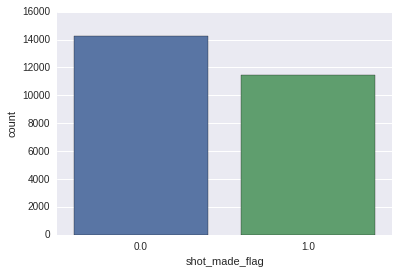

In [8]:
sns.countplot(df.shot_made_flag)

Not much of a difference here. No need to perform class balancing.

In [9]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

From the above description the features to check are - 
<ul>
<li><b>Numerical Features - </b>lat, loc_x, loc_y, lon, minutes_remaining, seconds_remaining, shot_distance</li>
<li><b>Categorical Features - </b>action_type, combined_shot_type, period, playoffs, season, shot_type, shot_zone_area, shot_zone_basic, shot_zone_range</li>
</ul>

#### Lets  explore the effect of features on the target variable one by one.

### Numerical Features
#### loc_x and loc_y - The points from which Kobe made the shots.

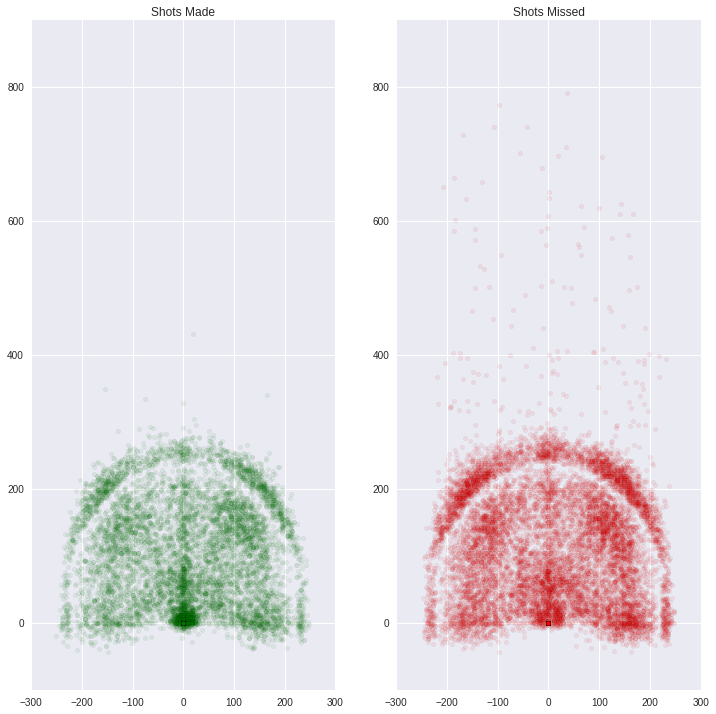

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.scatter(df.loc[df.shot_made_flag==1, 'loc_x'], df.loc[df.shot_made_flag==1, 'loc_y'], alpha=0.08, c='g')
plt.title('Shots Made')
plt.ylim(-100, 900)
plt.subplot(122)
plt.scatter(df.loc[df.shot_made_flag==0, 'loc_x'], df.loc[df.shot_made_flag==0, 'loc_y'], alpha=0.08, c='r')
plt.title('Shots Missed')
plt.ylim(-100, 900)
plt.show()

Obviously the distance matters, there are a lot of misses from far away the basket. In correspondence with intuition, the shots which he makes from near the basket have a higher success rate. Also number of misses are more from outer ring area. But there's a weird thing both have a lot of shots from 0,0. Lets check the count for better understanding.

In [11]:
c= df.loc[(df.loc_x==0) & (df.loc_y==0)]

c.shot_made_flag.value_counts()

1.0    2696
0.0    1625
Name: shot_made_flag, dtype: int64

It's counterintuitive but he misses about 40% shots which he attempts from just under the basket.

#### Minutes Remaining

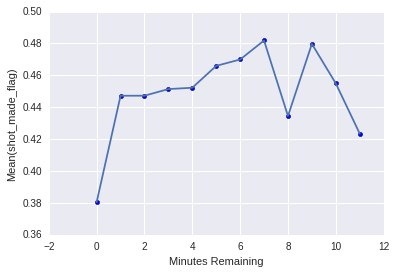

In [12]:
c = df.groupby('minutes_remaining')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.xlabel('Minutes Remaining')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()

Not much of a pattern here. Except for the 0th min. There's a sudden drop of mean of shot's made in the last minute.

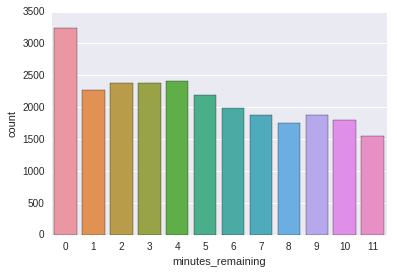

In [13]:
sns.countplot(df.minutes_remaining)

A lot of attempts are made in the last second.

#### Seconds remaining

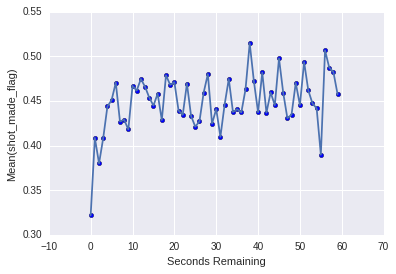

In [14]:
c = df.groupby('seconds_remaining')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.xlabel('Seconds Remaining')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()

Interesting to note that his performance decreases suddenly in the last 3 seconds of the game, as was seen with the minutes

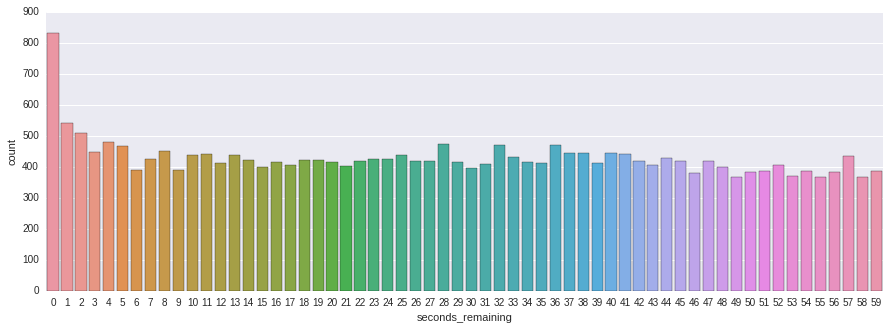

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(df.seconds_remaining)

A lot of attempts are made in the last second.

#### Shot Distance

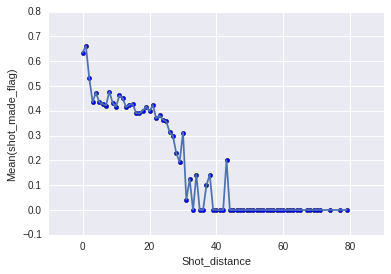

In [16]:
c = df.groupby('shot_distance')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.xlabel('Shot_distance')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()

Very intuitive. As the distance increases the accuracy decreases. An importance feature for prediction.

### Categorical variables

Lets explore the court area.
#### Shot_zone_area, shot_zone_basic, shot_zone_range with loc_x and loc_y and see the mean of shots made.

In [17]:
#Just a random color generator, will use for visualizations.
def color_generator(num_colors):
    colors = []
    for i in range(num_colors):
        colors.append((np.random.rand(), np.random.rand(), np.random.rand()))
    return colors

In [18]:
colors = color_generator(100)

In [19]:
#for plotting zone_wise points and checking their mean of target variable
def plot_zone_wise(zone_name):
    c_mean = df.groupby(zone_name)['shot_made_flag'].mean()
    plt.figure(figsize=(15,15))
    for i, area in enumerate(df[zone_name].unique()):
        plt.subplot(121)
        c = df.loc[(df[zone_name]==area)]
        plt.scatter(c.loc_x, c.loc_y,alpha=0.5 ,c=colors[i])
        plt.text(c.loc_x.mean(), c.loc_y.quantile(0.80), '%0.3f'%(c_mean[area]),size=15, bbox=dict(facecolor='red', alpha=0.5))
        plt.ylim(-100, 900)
    plt.legend(df[zone_name].unique())
    plt.title(zone_name)
    plt.show()

#### The values in red box shows the mean of shot_made_flag variable in that particular zone.

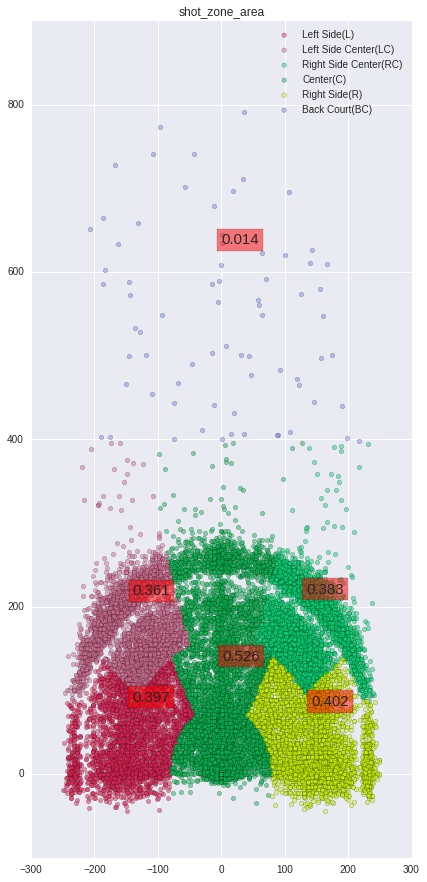

In [20]:
plot_zone_wise('shot_zone_area')

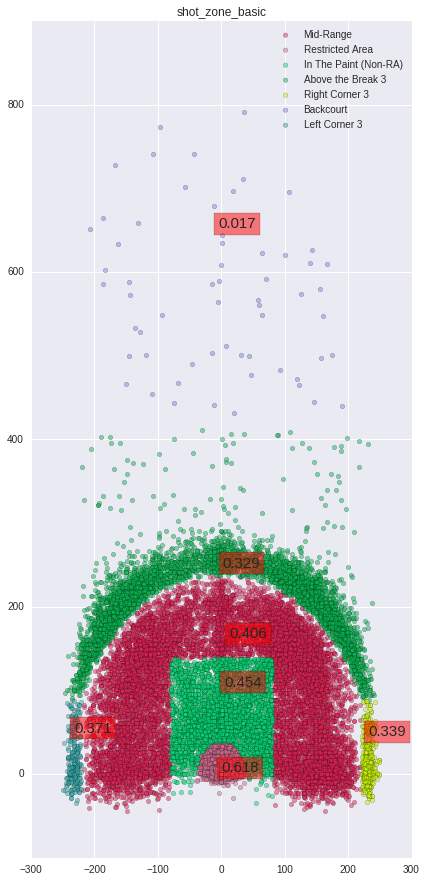

In [21]:
plot_zone_wise('shot_zone_basic')

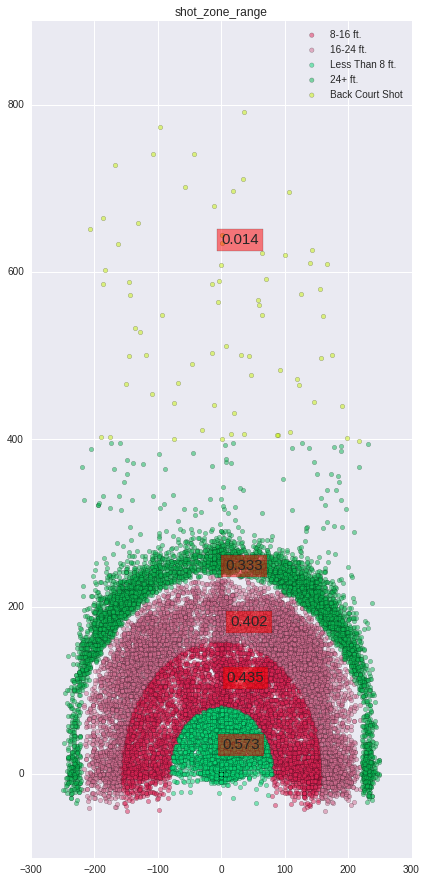

In [22]:
plot_zone_wise('shot_zone_range')

#### Period

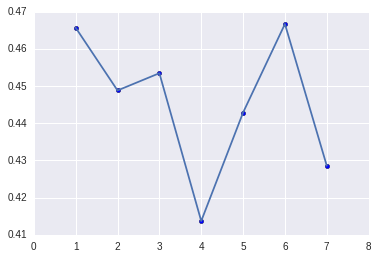

In [23]:
c = df.groupby('period')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.scatter(c.index, c.values)
plt.show()

Lot of variation. May prove to be an important feature.

#### Playoffs

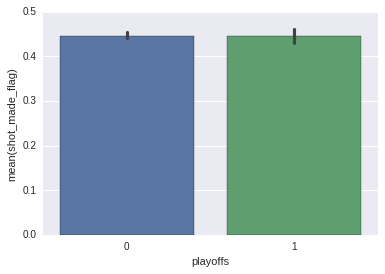

In [24]:
sns.barplot('playoffs', 'shot_made_flag', data=df)

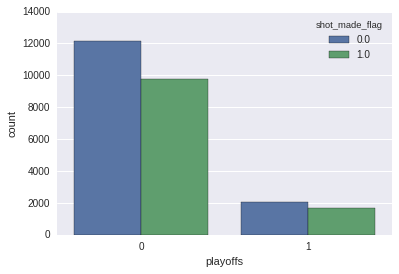

In [25]:
sns.countplot('playoffs', hue ='shot_made_flag', data=df)

Just two categories with near zero effect on the target variable.

#### Season

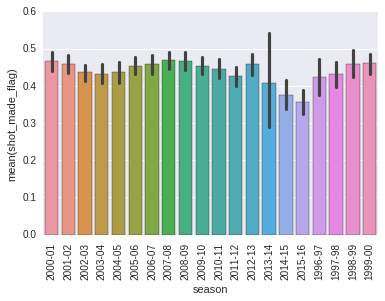

In [26]:
sns.barplot('season', 'shot_made_flag', data=df)
plt.xticks(rotation='vertical')
plt.show()

His performance is nearly consistent except for a few seasons.

#### Shot_type

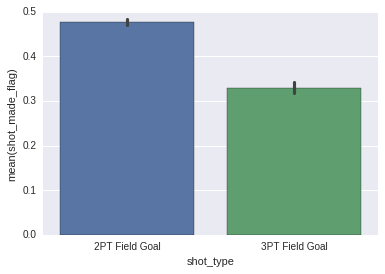

In [27]:
sns.barplot(df.shot_type, df.shot_made_flag)

#### Combined_shot_type

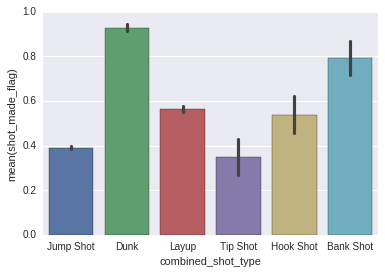

In [28]:
sns.barplot(df.combined_shot_type, df.shot_made_flag)

The combined shot type have a huge impact on the success of the shot. Dunk has the highest success rate followed by bank shot.

#### Action Type

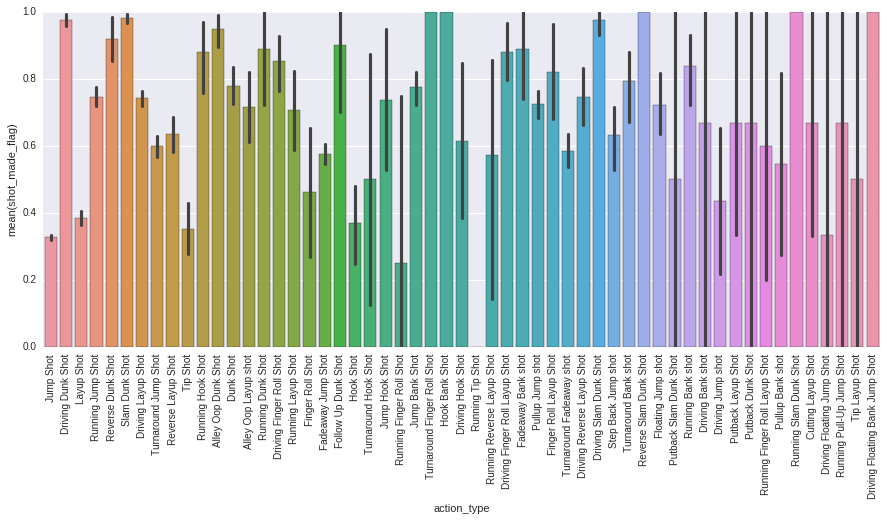

In [29]:
plt.figure(figsize=(15,6))
sns.barplot('action_type', 'shot_made_flag', data=df)
plt.xticks(rotation='vertical')
plt.show()

So these are the shot types. And they have a huge impact on the accuracy as we can see. Also there are specializations in every shot, for ex. running tip shot. And every added action could have some impact on the success of the shot. So counting every action as different can be helpful. 

### Data transformation and feature engineering

In [30]:
#getting combined data for feature transformation.
df = pd.read_csv('data.csv')

In [31]:
#The angle from which the shot was made.
df['angle'] = df.apply(lambda row: 90 if row['loc_y']==0 else m.degrees(m.atan(row['loc_x']/abs(row['loc_y']))),axis=1)

In [32]:
#Binning the angle, optimum size selected by cross validation.
df['angle_bin'] = pd.cut(df.angle, 7, labels=range(7))
df['angle_bin'] = df.angle_bin.astype(int)

#### Lets see its effect.

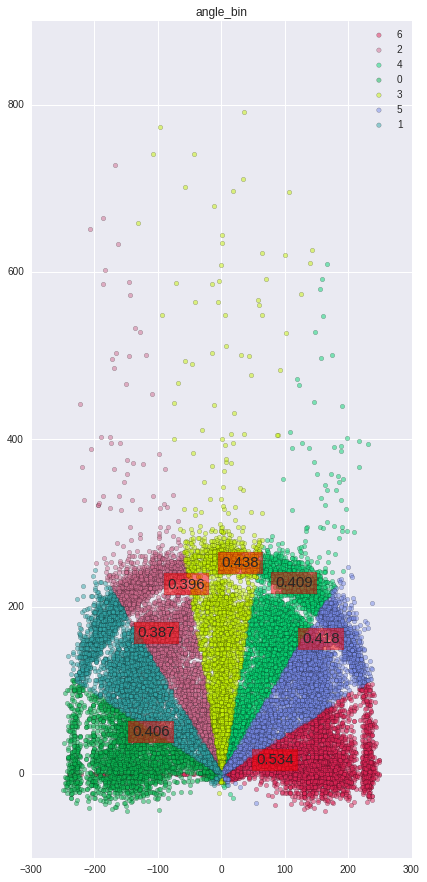

In [33]:
plot_zone_wise('angle_bin')

There's a pattern and difference in success rate.

In [34]:
#two types of valuein matchup @ and vs.. coding those values.
df['matchup_code'] = df.matchup.apply(lambda x: 0 if (x.split(' ')[1])=='@' else 1)

In [35]:
# Preprocessing the text for some words for later use.
df['action_type'] = df.action_type.apply(lambda x: x.replace('-', ''))
df['action_type'] = df.action_type.apply(lambda x: x.replace('Follow Up', 'followup'))
df['action_type'] = df.action_type.apply(lambda x: x.replace('Finger Roll','fingerroll'))

Using every action form the action type can help for ex. driving fingerroll layup shot consists 2 actions in a layup shot whereas a running layup shot consists only 1 action and running action could impact the success if applied either to layup or dunk shot so counting running as individual action can help.

In [36]:
#using countvectorizer to generate feature matrix
cv = CountVectorizer(max_features=50, stop_words=['shot'])

In [37]:
shot_features = cv.fit_transform(df['action_type']).toarray()

shot_features = pd.DataFrame(shot_features, columns=cv.get_feature_names())

In [38]:
shot_features.head()

,alley,back,bank,cutting,driving,dunk,fadeaway,fingerroll,floating,followup,hook,jump,layup,oop,pullup,putback,reverse,running,slam,step,tip,turnaround
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
#combining with the dataframe
df = pd.concat([df,shot_features], axis=1)

In [40]:
df['game_date'] = pd.to_datetime(df.game_date)

In [41]:
#His performance shouldn't depend on year or month but let's try.
df['game_date_month'] = df.game_date.dt.month

df['game_date_quarter'] = df.game_date.dt.quarter

In [42]:
#total time
df['time_remaining'] = df.apply(lambda row: row['minutes_remaining']*60+row['seconds_remaining'], axis=1)

In [43]:
#As seen from visualizations last 3 seconds success rate is lower.
df['timeUnder4'] = df.time_remaining.apply(lambda x: 1 if x<4 else 0)

Making radial grid as a feature.

In [44]:
df['distance_bin'] = pd.cut(df.shot_distance, bins=10, labels=range(10))

In [45]:
ang_dist = df.groupby(['angle_bin', 'distance_bin'])['shot_made_flag'].agg([np.mean],as_index= False).reset_index()

In [46]:
ang_dist['group'] = range(len(ang_dist))

ang_dist.drop('mean', inplace=True, axis=1)

In [47]:
ang_dist.head()

,angle_bin,distance_bin,group
0,0,0,0
1,0,1,1
2,0,2,2
3,0,3,3
4,1,0,4


In [48]:
ang_dist.shape

(44, 3)

In [49]:
df = df.merge(ang_dist, 'left', ['angle_bin', 'distance_bin'])

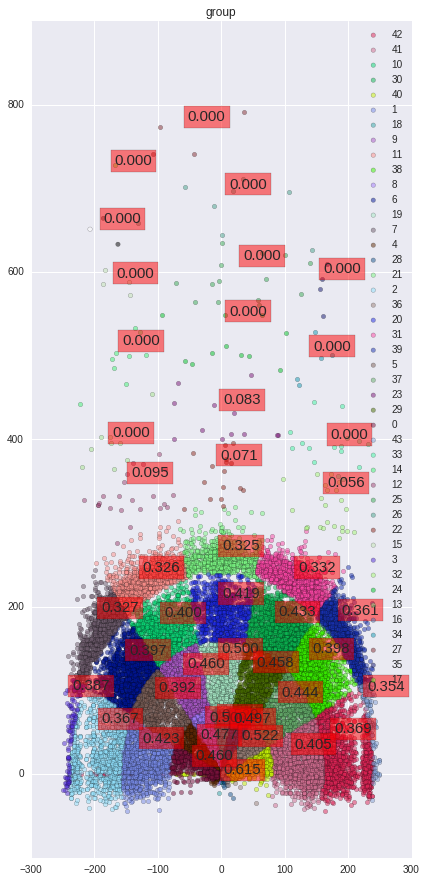

In [50]:
plot_zone_wise('group')

## --------------------------------------------------------------------------------------------------------------------

In [51]:
#The columns which we have now are
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id',
       'angle', 'angle_bin', 'matchup_code', 'alley', 'back', 'bank',
       'cutting', 'driving', 'dunk', 'fadeaway', 'fingerroll', 'floating',
       'followup', 'hook', 'jump', 'layup', 'oop', 'pullup', 'putback',
       'reverse', 'running', 'slam', 'step', 'tip', 'turnaround',
       'game_date_month', 'game_date_quarter', 'time_remaining', 'timeUnder4',
       'distance_bin', 'group'],
      dtype='object')

In [52]:
predictors = df.columns.drop(['game_event_id' #unique
                              , 'shot_made_flag'
                              , 'game_id' #unique
                              , 'shot_id' # id feature
                              , 'game_date'#other faetures from date used
                              , 'minutes_remaining'#transformed
                              , 'seconds_remaining'#transformed
                              ,'lat', 'lon' #same as loc_x, loc_y
                              , 'playoffs'#not important - from visualization
                              , 'team_id', 'team_name'#always same
                              , 'matchup' #transformed
                             ])

#### To not make the solution longer I have described below the steps that I took after this - 

<ol><li>Feature matrix transformation using one-hot encoding for non-tree based models - Logistic Regression, KNN, NaiveBayes etc. Since tree based models don't need explicit encoding.(Label encoding works for them)</li>
<li>Cross validation set generation  by chosing random data points (since competition also has the same pattern for test set)</li>
<li><b>Feature Selection</b> - Feature selection was done using following<ul>
<li>Visualization - A feature 'playoff' was removed by checking the visualizaion, as shown under categorical variable section.
</li><li><b>Recursive Feature Elimination</b> - Random Forest, Extra Trees and  Gradient Boosting classifier were used for the RFE and top 21 features (majority vote) were selected.</li></ul></li>
<li><b>Model Selection - </b> Different algorithm's 5-fold cross validation scores were compared for selecting final algorithm among <ul>
<li>Logistic Regression, KNN, NaiveBayes</li>
<li>Tree based - RandomForest, Gradient Boosting, Extra Trees, Extreme Gradient Boosting(XGBoost)</li>
<li>The scores of KNN and Naive Bayes were much worse and those algorithms can be eliminated.</li></ul>
</li>
<li><b>Hyperparameter optimization</b> - The parameters for LR, RF, GBM,ET and XGBoost were optimized using gridsearchCV and their best scores were compared. Finally XGBoost with below parameters came out as the best algorithm</li>
</ol>

In [53]:
#TOP 21
predictors = ['action_type', 'combined_shot_type', 'shot_distance',
       'shot_zone_basic', 'opponent', 'matchup_code',
       'bank', 'driving', 'dunk', 'fadeaway', 'jump', 'pullup', 'running',
       'slam', 'turnaround','timeUnder4', 'angle_bin','loc_x', 'loc_y','period', 'season']

In [54]:
#label encoding
le = LabelEncoder()
for col in predictors:
    if df[col].dtype=='object':
        df[col] = le.fit_transform(df[col])

In [55]:
#seperating train and test set
df_test = df.loc[df.shot_made_flag.isnull(), :]
df_test.index = range(len(df_test))

df.dropna(inplace=True)

df.index =  range(len(df))

In [56]:
#XGBoost with best parameters
xgb = xgboost.XGBClassifier(seed=1, learning_rate=0.01, n_estimators=500,silent=False, max_depth=7, subsample=0.6, colsample_bytree=0.6)

In [57]:
kf = KFold(n=len(df), shuffle=True,n_folds=5, random_state=50)

In [58]:
#5-fold cross validation
def run_test(predictors):
    all_score = []
    for train_index, test_index in kf:
        xgb.fit(df.loc[train_index, predictors], df.loc[train_index, 'shot_made_flag'])
        score = metrics.log_loss(df.loc[test_index, 'shot_made_flag'], xgb.predict_proba(df.loc[test_index, predictors])[:,1])
        all_score.append(score)
        print(score)
    print('Mean score =', np.array(all_score).mean())

In [59]:
run_test(predictors)

0.600516280518
0.603299580212
0.593809253668
0.611716143671
0.600362451457
Mean score = 0.601940741905


In [60]:
xgb.fit(df[predictors], df['shot_made_flag'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=False, subsample=0.6)

In [61]:
xgb.predict_proba(df_test[predictors])[:,1]

array([ 0.36089486,  0.36022702,  0.6154502 , ...,  0.73635   ,
        0.83065432,  0.3895821 ], dtype=float32)

In [62]:
df_test['shot_made_flag'] = xgb.predict_proba(df_test[predictors])[:,1]

In [63]:
submission = df_test[['shot_id', 'shot_made_flag']]

In [64]:
submission.to_csv('last_submission.csv', index=False)

### This submission score 0.60148 on the Kaggle LB. The submission was scored but not ranked since the competition has already ended. But according to the score this submission would've ranked #116 on the LB.